<a href="https://colab.research.google.com/github/ignacioPadilla/inteligenciaProyecto/blob/main/Red_final_proyecto_inteligencia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import time

import torch
from torch import nn
import torchvision

from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pandas as pd

from torchvision.ops import box_iou as box_iou
from torchsummary import summary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Localización de husos sigma en el EEG del sueño'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#TRAIN
#signals son las señales completas, cada señal se compone de 800 puntos(4463 señales).
dir_train_signals = path + "/train_signals.npy"
train_signals = torch.from_numpy(np.load(pathlib.Path(dir_train_signals))) #Tiene una señal muestreada con valores reales como Tensor



#marks son las respuestas, en cual punto comienza y termina el huso sigma.
dir_train_marks = path + "/train_marks.npy"
train_marks = np.load(pathlib.Path(dir_train_marks))  

#TEST
dir_test_signals = path + "/test_signals.npy"
test_signals = torch.from_numpy(np.load(pathlib.Path(dir_test_signals))) #Tiene una señal muestreada con valores reales como Tensor 

dir_test_marks = path + "/test_marks.npy"
test_marks = np.load(pathlib.Path(dir_test_marks))

#VALIDATION
dir_val_signals = path + "/val_signals.npy"
val_signals = torch.from_numpy(np.load(pathlib.Path(dir_val_signals))) #Tiene una señal muestreada con valores reales como Tensor

dir_val_marks = path + "/val_marks.npy"
val_marks = np.load(pathlib.Path(dir_val_marks))

##**Gráfico de una señal tipo signals**

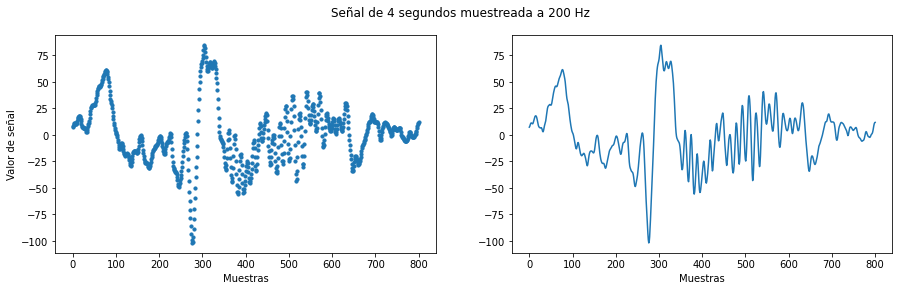

In [ ]:
muestras=np.linspace(0, 800, num=800)
# Crear la figura y los ejes
fig, ax = plt.subplots(1,2, figsize=(15,4))
ax[0].set_xlabel('Muestras')
ax[1].set_xlabel('Muestras')
ax[0].set_ylabel('Valor de señal')
plt.suptitle('Señal de 4 segundos muestreada a 200 Hz')
# Dibujar puntos
ax[0].scatter(muestras, train_signals[40], s=10)
ax[1].plot(muestras, train_signals[40])
# Mostrar el gráfico
plt.show()

In [ ]:
def crea_y(mark):
  muestras,dim = mark.shape
  salida=np.zeros(800)
  for i in range(muestras):
    vector = np.zeros(800)
    inicio = mark[i][0]
    final = mark[i][1]
    while inicio <= final:
      vector[inicio] = 1
      inicio = inicio+1
    salida = np.vstack([salida,vector])
  salida = np.delete(salida, 0, axis=0)
  return salida

In [ ]:
y_train = crea_y(train_marks)
y_test = crea_y(test_marks)
y_val = crea_y(val_marks)

##**Normalización de datos**

In [ ]:
for i in range(4463):
  train_signals[i]=(train_signals[i]-train_signals[i].mean())/(train_signals[i].std())

for i in range(len(val_signals)):
  val_signals[i]=(val_signals[i]-val_signals[i].mean())/(val_signals[i].std())



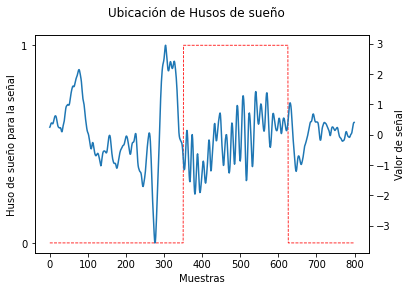

In [ ]:
### sanity check
index = 40

fig, ax = plt.subplots()
ax.plot(y_train[index,:], linestyle='dashed', linewidth=0.8, c='red')
ax.set_xlabel('Muestras')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(train_signals[index,:])
ax2.set_ylabel('Valor de señal')
plt.show()

##**Implementación red neuronal**

In [ ]:
#De numpy a tensor
y_train = torch.tensor(y_train, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64)
y_test = torch.tensor(y_test, dtype=torch.float64)

#Se cambian dimensiones a las señales tipo signals para que tengan un canal y poder ocupar red convolucional
X_train = torch.reshape(train_signals, (len(train_signals), 1, 800)) ###,(4463,1,800)) 
X_val = torch.reshape(val_signals,(len(val_signals),1,800))              
X_test = torch.reshape(test_signals,(len(test_signals),1,800))

In [ ]:
#DATASETS
train_dataset = torch.utils.data.TensorDataset(X_train, y_train) 
val_dataset = torch.utils.data.TensorDataset(X_val,y_val)
test_dataset =torch.utils.data.TensorDataset(X_test,y_test)

Cambio en las dimensiones al aplicar red neuronal a los datos.

In [ ]:
example_image, example_class = train_dataset[40]
conv_layer = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=1)
output_image= conv_layer(example_image)
print(f"Input image shape: {example_image.shape}")
print(f"Output image shape: {output_image.shape}")

Input image shape: torch.Size([1, 800])
Output image shape: torch.Size([10, 800])


##**Red neuronal**

In [ ]:
class CNNModel2(nn.Module):
    def __init__(
        self,
        dropout_p,
    ):
        super().__init__()
        
        self.conv_blocks = nn.Sequential(
            # Bloque 1

            nn.Conv1d(1, 100, kernel_size=200,padding="same"), 
            nn.ReLU(),

            # Bloque 2

            nn.Conv1d(100, 50, kernel_size=100,padding="same"),
            nn.ReLU(),
          

            # Bloque 3

            nn.Conv1d(50, 25,  kernel_size=50,padding="same"),
            nn.ReLU(),

            # Bloque 4

            nn.Conv1d(25, 1,  kernel_size=20,padding="same"),
            nn.ReLU()
        )

        #aqui pasa a vectores 
        self.mlp = nn.Sequential(
            nn.Flatten(),
            # El primer valor de esta capa lineal cambia si se utilizan distintos bloques    ### ASI DEBERIA SER PERO EN SU CASO ESTÁN
                                                        ### USANDO KERNEL=1, LO CUAL ACOMPAÑADO DE STRIDE=1 Y SIN PADDING LES DEJA EL TAMAÑO
                                                        ### SIN MODIFICARSE (EXCEPTO EL NUMERO DE CANALES)
            nn.Linear(800,256),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(256, 800),
            nn.Sigmoid()                           ### SI UTILIZAN SIGMOIDE DENTRO DEL MODELO ENTONCES EN CASO DE USAR
                                ### CROSS ENTROPY BINARIA DEBEN USAR BCELoss() (no usar BCELossWithLogits())
        )

        self.net = nn.Sequential(
            self.conv_blocks,
            self.mlp,
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 3, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    ax[2].plot(epochs, curves['iou'], label='IoU')
    ax[2].set_xlabel('Epoch')
    ax[2].set_ylabel('IoU')
    ax[2].set_title('IoU evolution during training')
    ax[2].legend()

    plt.show()

In [ ]:
def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    #Modelo entrenado con x_batch señales, el cual debería entregar una predicción de 800 números 
    #y a esa predicción hecha por el modela la llamamos "y_predicted"
    y_predicted = model(x_batch) #modelo entrega arreglo de 800 números con valores del 0 al 1
    #Loss es el criteio a utilizar para calcular la diferencia entre el "y_predicted"  y el "y_batch", para saber cuanto nos estamos equivocando
    loss = criterion(y_predicted, y_batch.float()) 

    # Actualización de parámetros
    optimizer.zero_grad() 
    loss.backward() #el error debido a loss se propaga hacia atras
    optimizer.step()
    return y_predicted, loss #train_step entrena la red con señales de tamaño x_batch, luego calcula el loss para finalmente propagar el error hacia atras


###PARA VALIDACION####
def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0 #Los que iremos acumulando a medida que recorremos las señales y hacemos una predicción
    cumulative_predictions = 0
    union = 0
    intersection=0
    ### Y SI SE CAMBIA EL SET DE VALIDACION? ESTO ESTÁ MAL
    ###data_count = 1808*800   #0
    data_count1=0
    for x_val, y_val in val_loader:  #toma una señal de x_val y su Clase de y_val y lo hace para todo el dataset val_loader
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val) #Hace una predicción para x_val con el modelo de redes neuronales. 

        loss = criterion(y_predicted, y_val.float()) #Se calcula un loss para ver en cuanto difiere la predicción de la red con el valor real que deberia dar

        class_prediction = (y_predicted >= 0.5).long() #Esto trasnforma a 0 o 1 el arreglo de 800 elementos que tenemos

        cumulative_predictions += (y_val == class_prediction).sum().item() #SUMA CASOS CORRECTAMENTE PREDICHOS
        cumulative_loss += loss.item() #EN EL LOSS SE CALCULA UN PROMEDIO DE CADA BATCH; POR ENDE SOLO SE NECESITA AL FINAL DIVIDIR POR N_BATCHs
        data_count1 += y_val.shape[0]*800   #EN EL ACC SE CALCULA POR CADA PUNTO DE CADA SEÑAL
        #CAMBIOS DESDE ACÁ 
        union += (class_prediction +  y_val - class_prediction*y_val).sum()
        intersection += (class_prediction * y_val).sum()
        iou = ((intersection)/(union+1e-8)).item()
  
    
    val_acc = cumulative_predictions/data_count1 ###/ data_count
    val_loss = cumulative_loss / len(val_loader) ###data_count1 ################

    return val_acc, val_loss, iou


def train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    ###n_evaluations_per_epoch=6,  ### ESTO NO ES NECESARIO, EL NUM DE EVALUACIONES POR EPOCA SUELE ESTAR DADO POR EL N_BATCHES, A MENOS Q SU 
    ### ENTRENAMIENTO SEA MUY LENTO
    use_gpu=False,
    data_augmentation=False,
):



    if use_gpu:
        model.cuda()

    # Definición de dataloader

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=use_gpu)

    ### ESTAN TRABAJANDO CON IMAGENES Y ESO USA MUCHA MEMORIA, PROBABLEMENTE NO LES VAN A ACEPTAR UN BATCH SIZE TAN GRANDE
    val_loader = torch.utils.data.DataLoader(val_dataset, #batch_size=len(val_dataset), 
                                             batch_size=batch_size, shuffle=False, pin_memory=use_gpu) #batch size es de tamaño 1808

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
        "iou": [],
    }

    t0 = time.perf_counter()

    ###iteration = 0

    n_batches = len(train_loader) #deberia ser 4463 

    for epoch in range(epochs): #si epochs es 4, entonces toma valores del 0 al 3
        print(f"\rEpoch {epoch + 1}/{epochs}")
        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        train_loss_count = 0
        train_acc_count = 0
###########################
        # Entrenamiento del modelo
        model.train()
        iteration = 0
        for i, (x_batch, y_batch) in enumerate(train_loader):
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu) #Entrega el y predicted y el loss para una epoca

            cumulative_train_loss += loss.item() #Se acumula loss a medida que pasamos por los x_batch
            train_loss_count += 1   #800   ### LA FUNCION DE LOSS YA CALCULA UN PROMEDIO, POR ESO SE SUMA 1 Y NO 800
            ###train_acc_count =4463*800   #Antes tenia y_batch.shape[0] #Puse eso pq es el total de casos de 0 y 1 de todo el dataset
            ### ESE ES EL VALOR FINAL, SI VAN REPORTANDO SUS RESULTADOS A LO LARGO DEL ENTRENAMIENTO DENTRO DE CADA EPOCA ESTO ESTÁ MAL
            ### DEBEN IR SUMANDO CADA BATCH A MEDIDA QUE SE VA RECORRIENDO EL TRAIN SET
            ### (OJO, ADEMAS, QUE EL VALOR DEL BATCH NO SIEMPRE ES EL MISMO; PORQUE SI EL LARGO DEL DATASET NO ES MULTIPLO DEL BATCH_SIZE ENTONCES
            ### EL ULTIMO BATCH VA A SER MÁS CHICO QUE LOS DEMÁS
            train_acc_count += y_batch.shape[0]*800


            # Calculamos número de aciertos
            class_prediction = (y_predicted >= 0.5).long()
            cumulative_train_corrects += (y_batch == class_prediction).sum().item()

            if (i%5 == 0) and (i > 0):
                train_loss = cumulative_train_loss / train_loss_count
                train_acc = cumulative_train_corrects / train_acc_count

                print(f"Iteration {iteration} - Batch {i}/{len(train_loader)} - Train loss: {train_loss}, Train acc: {train_acc}")

            iteration += 1

        model.eval()
        with torch.no_grad():
            val_acc, val_loss, iou = evaluate(val_loader, model, criterion, use_gpu)

        print(f"Val loss: {val_loss}, Val acc: {val_acc}, IoU: {iou}")

        train_loss = cumulative_train_loss / train_loss_count
        train_acc = cumulative_train_corrects / train_acc_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)
        curves["iou"].append(iou)

    print()
    print(f"Tiempo total de entrenamiento: {time.perf_counter() - t0:.4f} [s]")

    model.cpu()



    return curves, model   #### PARA RECUPERAR EL MODELO QUE ENTRENARON, EN ESTE CASO SE RETORNA EL MODELO CON LOS PESOS ACTUALIZADOS POR ULTIMA VEZ.
    #### LO OTRO QUE SE SUELE HACER ES EN CADA EPOCA COMPARAR LOS ACCURACY DE VALIDACION POR SI OCURRE OVERFIT Y GUARDAR LOS PESOS DEL MODELO CON MAYOR
    #### ACCURACY DE VALIDACION COMO "BEST_MODEL" Y DESPUES RETORNAR ESO (ES COMO SIMILAR A USAR EARLY STOPPING)

In [ ]:
##Bloque para aplicar IoU final.

#función para el umbral, pasar a 0s y 1s.
def umbral(x):
  x_pred = np.zeros(x.shape)    ### PREFIERO HACER UN ARREGLO EXTRA PARA GUARDAR LA PREDICCION PORQUE DE OTRA MANERA A VECES EXISTE RIESGO
  ### DE QUE SE MODIFIQUE EL ARREGLO ORIGINAL Y ESO PUEDE TRAER PROBLEMAS.  NO ESO SI ESO OCURRE EXACTAMENTE EN ESTE CASO PERO YO PREFIERO
  ### TOMAR LOS RESGUARDOS jaja.
  for i in range(len(x[0])): 
    if x[0][i]>0.4:
      x_pred[0][i]=1

  return x_pred


#función para hacer continuo el resultado.
def linealizar_resultado(example_image2):
  example_image = example_image2.squeeze()

  inicio = 0

  for i in range(len(example_image)):
    if example_image[i] == 1:
      inicio = i
      break 
    

  for j in reversed(range(len(example_image))):
    if example_image[j] == 1:
      final = j
      break

  x_lin = np.zeros(example_image.shape[0])
  for h in range(len(x_lin)):
    if h >= inicio and h<= final:
      x_lin[h]=1
  return x_lin

#obtiene punto inicial y final de la señal.
def obt_puntos(x_lin,marks):
  for i in range(800):
    if x_lin[i]==1:
      inicio_pred = i
      break
  for j in range(800):
    if marks[j]==1:
      inicio_marks = j
      break
  for o in reversed(range(800)):
    if x_lin[o]==1:
      final_pred = o
      break
  for p in reversed(range(800)):
    if marks[p]==1:
      final_marks = p
      break
  return (inicio_pred,final_pred,inicio_marks,final_marks)


def iou(prediction,mark):
  #Tomo el comienzo y el final de la prediccion y los label
  x1_p=prediction[0]
  x2_p=prediction[1]
  x1_m=mark[0]
  x2_m=mark[1]

  #para la unión
  x1_u = min(x1_p,x1_m)
  x2_u = max(x2_p,x2_m)
  u_long = x2_u - x1_u + 1

  #para la intersección
  x1_i = max(x1_p,x1_m)
  x2_i = min(x2_p,x2_m)
  i_long = x2_i - x1_i + 1

  #iou
  resultado = i_long / u_long
  if resultado <0:
    resultado = 0

  return resultado


def iou_final(final_model,test_dataset):
  valores_iou=[]
  largo = len(test_dataset)
  iou_a = 0
  for muestra in test_dataset:
    example_image, example_class = muestra
    a = umbral(final_model(example_image))
    b = linealizar_resultado(a)
    c = obt_puntos(b,example_class)
    pre = c[0],c[1]
    m = c[2],c[3]
    iou_a = iou(pre,m)
    valores_iou.append(iou_a)

  plt.hist(valores_iou,bins = 10)
  plt.title("Frecuencia de IoU para dataset de validación")
  plt.xlabel("IoU")
  plt.ylabel("Frecuencia")
  plt.show()
  return valores_iou

def histograma_iou(valores_iou):
  plt.hist(valores_iou,bins = 10)
  plt.title("Frecuencia de IoU para dataset de validación")
  plt.xlabel("IoU")
  plt.ylabel("Frecuencia")
  plt.show()

Epoch 1/15
Iteration 5 - Batch 5/298 - Train loss: 0.6926181217034658, Train acc: 0.5076805555555556
Iteration 10 - Batch 10/298 - Train loss: 0.6882745298472318, Train acc: 0.5317272727272727
Iteration 15 - Batch 15/298 - Train loss: 0.6811454147100449, Train acc: 0.5520208333333333
Iteration 20 - Batch 20/298 - Train loss: 0.6739439283098493, Train acc: 0.5671190476190476
Iteration 25 - Batch 25/298 - Train loss: 0.6652174935891078, Train acc: 0.5819134615384616
Iteration 30 - Batch 30/298 - Train loss: 0.6576533836703147, Train acc: 0.5938521505376344
Iteration 35 - Batch 35/298 - Train loss: 0.6495600044727325, Train acc: 0.605125
Iteration 40 - Batch 40/298 - Train loss: 0.641005805352839, Train acc: 0.6153231707317073
Iteration 45 - Batch 45/298 - Train loss: 0.6314393450384554, Train acc: 0.6256902173913044
Iteration 50 - Batch 50/298 - Train loss: 0.6225006276485967, Train acc: 0.6349362745098039
Iteration 55 - Batch 55/298 - Train loss: 0.6139528187257903, Train acc: 0.6435297

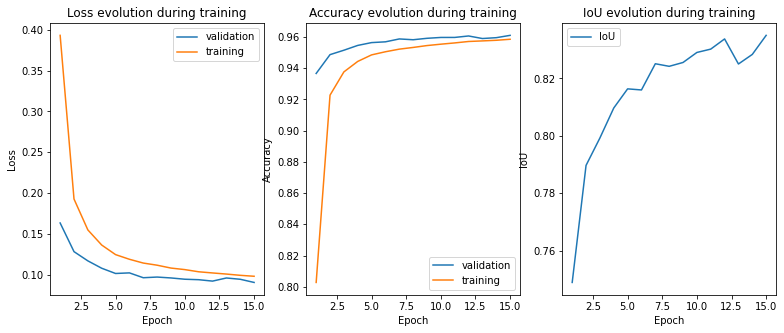

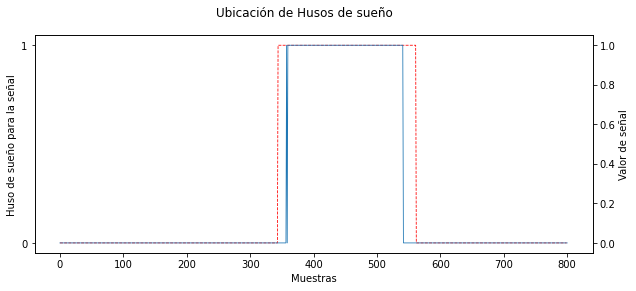

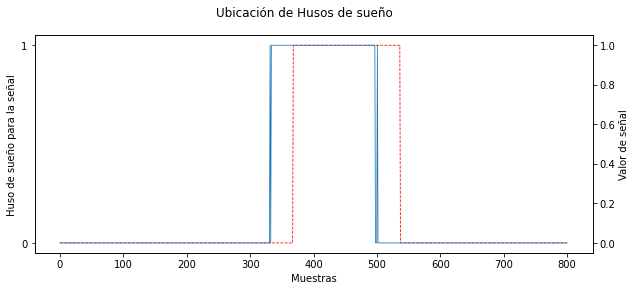

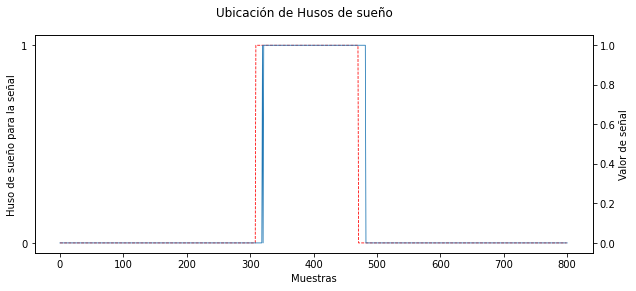

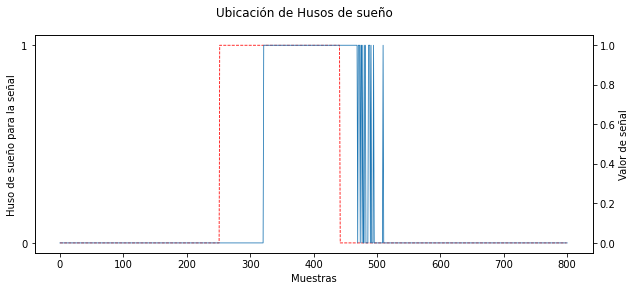

In [ ]:
lr = 0.0001
dropout_p = 0.5
batch_size = 15
criterion = nn.BCELoss() ##nn.L1Loss(reduction='sum')#BCEwithLogitsLoss() #¿Para este caso hay que borrar la funcion de activacion Sigmoid?

epochs = 15
model = CNNModel2(dropout_p)

curves, final_model = train_model(
    model,
    train_dataset,
    val_dataset,
    epochs,
    criterion,
    batch_size,
    lr,
    use_gpu=True
)

show_curves(curves)



#y_predicted = model(example_image)
#y_predicted

##################################
index = 25

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()


#######################################

#y_predicted = model(example_image)
#y_predicted


index = 50

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 91

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()



#############################################

#y_predicted = model(example_image)
#y_predicted


index = 33

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
# Crear la figura y los ejes


fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

In [ ]:
#Evaluación para obtener los recursos computacionales del modelo.

import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
import torchsummary as ts #paquete que permite hacer diagnosticos, es decir parametros de una red, como se convierte la info de una red
network = CNNModel2(dropout_p=0.5)
network = network.to(device)
print(network)
ts.summary(network.to(device), (1, 800), device='cuda') #(red neuronal, tamaño de los datos de entrada,cuda)
     

CNNModel2(
  (conv_blocks): Sequential(
    (0): Conv1d(1, 100, kernel_size=(200,), stride=(1,), padding=same)
    (1): ReLU()
    (2): Conv1d(100, 50, kernel_size=(100,), stride=(1,), padding=same)
    (3): ReLU()
    (4): Conv1d(50, 25, kernel_size=(50,), stride=(1,), padding=same)
    (5): ReLU()
    (6): Conv1d(25, 1, kernel_size=(20,), stride=(1,), padding=same)
    (7): ReLU()
  )
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=800, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=800, bias=True)
    (5): Sigmoid()
  )
  (net): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 100, kernel_size=(200,), stride=(1,), padding=same)
      (1): ReLU()
      (2): Conv1d(100, 50, kernel_size=(100,), stride=(1,), padding=same)
      (3): ReLU()
      (4): Conv1d(50, 25, kernel_size=(50,), stride=(1,), padding=same)
      (5): ReLU()
      (6): Conv1d(25, 1, kerne

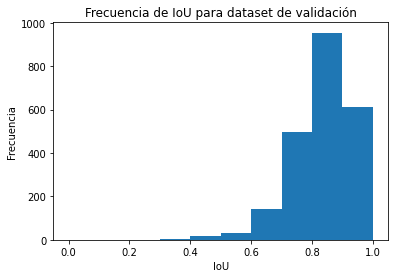

In [ ]:
#Mostrar el histograma obtenido del entrenamiento.
lista_iou = iou_final(final_model,test_dataset)

In [ ]:
#función para obtener el iou en el conjunto de test (para obtener valor promedio)
def iou_promedio_test(lista_iou):
  suma = 0
  for valor in lista_iou:
    suma += valor
  iou_promedio = suma/len(lista_iou)
  return iou_promedio

In [ ]:
#obtiene el valor promedio de iou del conjunto de test luego del entrenamiento
iou_promedio_test(lista_iou)

0.834105674130851

In [ ]:
#muestra los peores resultados según el iou.
indice = 0
for valor in lista_iou:
  if valor < 0.4:
    print(valor,indice)
  indice += 1  

0.23039215686274508 841
0.3453815261044177 902
0.31899641577060933 1443
0.3884297520661157 1601
0 1627
0.3717948717948718 1696
0.37433155080213903 1708


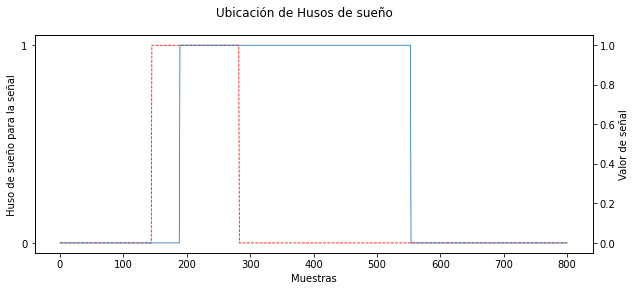

In [ ]:
index = 841

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
example_image=linealizar_resultado(example_image)
# Crear la figura y los ejes

fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

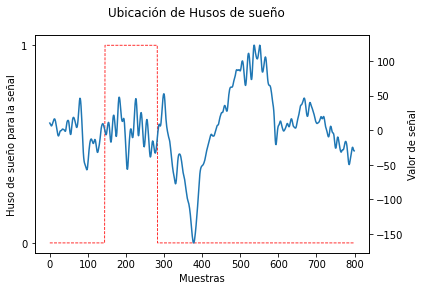

In [ ]:
### sanity check
index = 841

fig, ax = plt.subplots()
ax.plot(y_test[index,:], linestyle='dashed', linewidth=0.8, c='red')
ax.set_xlabel('Muestras')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(test_signals[index,:])
ax2.set_ylabel('Valor de señal')
plt.show()

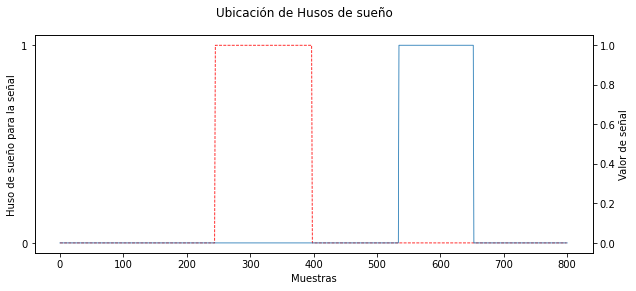

In [ ]:
index = 1627

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
example_image=linealizar_resultado(example_image)
# Crear la figura y los ejes

fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

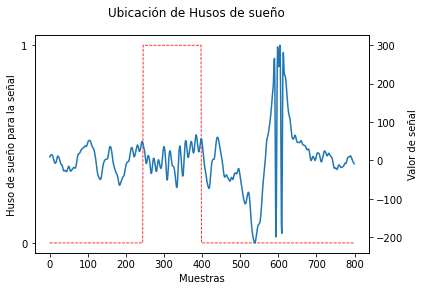

In [ ]:
### sanity check
index = 1627

fig, ax = plt.subplots()
ax.plot(y_test[index,:], linestyle='dashed', linewidth=0.8, c='red')
ax.set_xlabel('Muestras')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(test_signals[index,:])
ax2.set_ylabel('Valor de señal')
plt.show()

In [ ]:
#Muestra el mejor ejemplo obtenido en los resultados.
indice = 0
cuenta = 0
for valor in lista_iou:
  if valor > 0.8:
    cuenta += 1
    #print(valor,indice)
  indice += 1  
print(cuenta)

1479


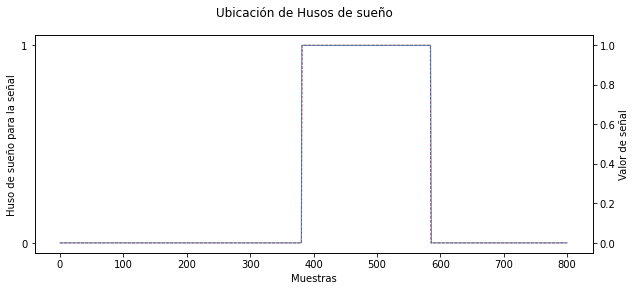

In [ ]:
index = 1308

example_image, example_class = test_dataset[index]
muestras=np.linspace(0, 800, num=800)

example_image= final_model(example_image).detach().numpy()
example_image=umbral(example_image)
example_image=linealizar_resultado(example_image)
# Crear la figura y los ejes

fig, ax = plt.subplots(figsize=(10,4))
plt.xlabel('Muestras')
ax.plot(example_class, linestyle='dashed', linewidth=0.8, c='red')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(muestras, example_image.squeeze(), linewidth=0.8)
ax2.set_ylabel('Valor de señal')
# Mostrar el gráfico
plt.show()

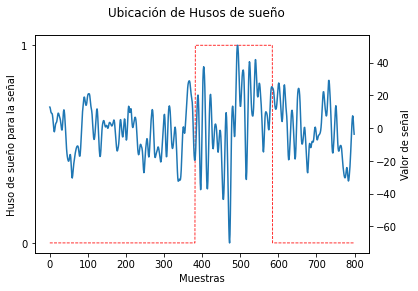

In [ ]:
### sanity check
index = 1308

fig, ax = plt.subplots()
ax.plot(y_test[index,:], linestyle='dashed', linewidth=0.8, c='red')
ax.set_xlabel('Muestras')
ax.set_ylabel('Huso de sueño para la señal')
ax.set_yticks([0, 1])
plt.suptitle('Ubicación de Husos de sueño')
ax2 = ax.twinx()
ax2.plot(test_signals[index,:])
ax2.set_ylabel('Valor de señal')
plt.show()